### 1. Import Libraries

In [1]:
# Cell 1: imports + config cơ bản
import os
import random
import time
from pathlib import Path
from collections import Counter

import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import sacrebleu  # BLEU
import spacy

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

# Repro
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Device: cpu


### 2. Data path

In [2]:
# Cell 2: set paths and quick check
DATA_DIR = Path("../data")  # sửa theo vị trí notebook của bạn
files = {
    "train_en": DATA_DIR / "train.en",
    "train_fr": DATA_DIR / "train.fr",
    "val_en":   DATA_DIR / "val.en",
    "val_fr":   DATA_DIR / "val.fr",
    "test_en":  DATA_DIR / "test_2018_flickr.en",
    "test_fr":  DATA_DIR / "test_2018_flickr.fr",
}
for k, p in files.items():
    print(k, "->", p.exists())


train_en -> True
train_fr -> True
val_en -> True
val_fr -> True
test_en -> True
test_fr -> True


### 3. Load raw data

In [3]:
# Cell 3: load raw sentences into lists (strip newline)
def read_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

train_src = read_lines(files["train_en"])
train_tgt = read_lines(files["train_fr"])
val_src = read_lines(files["val_en"])
val_tgt = read_lines(files["val_fr"])
test_src = read_lines(files["test_en"])
test_tgt = read_lines(files["test_fr"])

print("train size:", len(train_src))
print("val size:", len(val_src))
print("test size:", len(test_src))
# print sample
for i in range(3):
    print("EN:", train_src[i])
    print("FR:", train_tgt[i])
    print("---")


train size: 29000
val size: 1014
test size: 1071
EN: Two young, White males are outside near many bushes.
FR: Deux jeunes hommes blancs sont dehors près de buissons.
---
EN: Several men in hard hats are operating a giant pulley system.
FR: Plusieurs hommes en casque font fonctionner un système de poulies géant.
---
EN: A little girl climbing into a wooden playhouse.
FR: Une petite fille grimpe dans une maisonnette en bois.
---


### 4. Load Tokenizers

In [4]:
# Load tokenizer
spacy_en = spacy.load('en_core_web_sm')
spacy_fr = spacy.load('fr_core_news_sm')

# tokenization function
def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

# quick test
print(tokenize_en("A man is playing guitar."))
print(tokenize_fr("Un homme joue de la guitare."))

['a', 'man', 'is', 'playing', 'guitar', '.']
['un', 'homme', 'joue', 'de', 'la', 'guitare', '.']


### 5. Tokenize all splits

In [5]:
# Cell 5: tokenize (we store token lists)
def tokenize_sentences(sentences, tokenizer_fn):
    return [tokenizer_fn(s) for s in tqdm(sentences, desc="tokenizing")]

train_src_tok = tokenize_sentences(train_src, tokenize_en)
train_tgt_tok = tokenize_sentences(train_tgt, tokenize_fr)
val_src_tok   = tokenize_sentences(val_src, tokenize_en)
val_tgt_tok   = tokenize_sentences(val_tgt, tokenize_fr)
test_src_tok  = tokenize_sentences(test_src, tokenize_en)
test_tgt_tok  = tokenize_sentences(test_tgt, tokenize_fr)

# show sample
print(train_src_tok[0])
print(train_tgt_tok[0])

tokenizing:   0%|          | 0/29000 [00:00<?, ?it/s]

tokenizing:   0%|          | 0/29000 [00:00<?, ?it/s]

tokenizing:   0%|          | 0/1014 [00:00<?, ?it/s]

tokenizing:   0%|          | 0/1014 [00:00<?, ?it/s]

tokenizing:   0%|          | 0/1071 [00:00<?, ?it/s]

tokenizing:   0%|          | 0/1071 [00:00<?, ?it/s]

['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']


### 6. Build Vocabulary

In [6]:
# Cell 6: Vocab class and build vocab
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"

class Vocab:
    def __init__(self, tokens_list, min_freq=2, max_size=None):
        counter = Counter()
        for toks in tokens_list:
            counter.update(toks)
        self.itos = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
        for tok, freq in counter.most_common():
            if freq < min_freq:
                continue
            if tok in self.itos:
                continue
            self.itos.append(tok)
            if max_size and len(self.itos) >= max_size:
                break
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}
    def __len__(self):
        return len(self.itos)
    def numericalize(self, tokens):
        return [self.stoi.get(t, self.stoi[UNK_TOKEN]) for t in tokens]

# build vocabs
MAX_VOCAB = 10000
MIN_FREQ = 2

src_vocab = Vocab(train_src_tok, min_freq=MIN_FREQ, max_size=MAX_VOCAB)
tgt_vocab = Vocab(train_tgt_tok, min_freq=MIN_FREQ, max_size=MAX_VOCAB)

print("src vocab size:", len(src_vocab))
print("tgt vocab size:", len(tgt_vocab))
print("sample idx:", src_vocab.stoi.get("a"), tgt_vocab.stoi.get("un"))

src vocab size: 5893
tgt vocab size: 6470
sample idx: 4 4


### 7. Dataset & collate_fn

In [7]:
# Cell 7: Dataset and collate_fn
class TranslationDataset(Dataset):
    def __init__(self, src_tok_list, tgt_tok_list, src_vocab, tgt_vocab, max_len=100):
        assert len(src_tok_list) == len(tgt_tok_list)
        self.src = src_tok_list
        self.tgt = tgt_tok_list
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len
    def __len__(self):
        return len(self.src)
    def __getitem__(self, idx):
        src_tokens = self.src[idx][:self.max_len]
        tgt_tokens = self.tgt[idx][:self.max_len-2]  # leave room for sos/eos
        src_ids = self.src_vocab.numericalize(src_tokens)
        tgt_ids_in = [self.tgt_vocab.stoi[SOS_TOKEN]] + self.tgt_vocab.numericalize(tgt_tokens)
        tgt_ids_out = self.tgt_vocab.numericalize(tgt_tokens) + [self.tgt_vocab.stoi[EOS_TOKEN]]
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids_in, dtype=torch.long), torch.tensor(tgt_ids_out, dtype=torch.long)

def collate_fn(batch):
    src_batch, tgt_in_batch, tgt_out_batch = zip(*batch)
    src_lens = torch.tensor([len(x) for x in src_batch], dtype=torch.long)
    src_pad = pad_sequence(src_batch, batch_first=True, padding_value=src_vocab.stoi[PAD_TOKEN])
    tgt_in_pad = pad_sequence(tgt_in_batch, batch_first=True, padding_value=tgt_vocab.stoi[PAD_TOKEN])
    tgt_out_pad = pad_sequence(tgt_out_batch, batch_first=True, padding_value=tgt_vocab.stoi[PAD_TOKEN])
    return src_pad, src_lens, tgt_in_pad, tgt_out_pad

# create datasets and dataloaders
BATCH_SIZE = 64
train_ds = TranslationDataset(train_src_tok, train_tgt_tok, src_vocab, tgt_vocab)
val_ds   = TranslationDataset(val_src_tok, val_tgt_tok, src_vocab, tgt_vocab)
test_ds  = TranslationDataset(test_src_tok, test_tgt_tok, src_vocab, tgt_vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# quick check shapes
for src_pad, src_lens, tgt_in_pad, tgt_out_pad in train_loader:
    print("src_pad", src_pad.shape)
    print("src_lens", src_lens.shape)
    print("tgt_in_pad", tgt_in_pad.shape)
    print("tgt_out_pad", tgt_out_pad.shape)
    break

src_pad torch.Size([64, 26])
src_lens torch.Size([64])
tgt_in_pad torch.Size([64, 29])
tgt_out_pad torch.Size([64, 29])


### 8. Model: Encoder, Decoder, Seq2Seq

In [8]:
# Cell 8: model definitions
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers=1, dropout=0.):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=src_vocab.stoi[PAD_TOKEN])
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_lengths):
        # src: [B, S]
        embedded = self.dropout(self.embedding(src))  # [B, S, E]
        # pack for efficiency (optional but recommended if using variable lengths)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.rnn(packed)
        # hidden, cell: [n_layers, B, hid_dim]
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers=1, dropout=0.):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=tgt_vocab.stoi[PAD_TOKEN])
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_step, hidden, cell):
        # input_step: [B, 1]
        embedded = self.dropout(self.embedding(input_step))  # [B,1,emb]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))  # output: [B,1,hid]
        pred = self.fc_out(output.squeeze(1))  # [B, output_dim]
        return pred, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, src_len, tgt_in, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt_in.size(1)
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)
        hidden, cell = self.encoder(src, src_len)
        input_tok = tgt_in[:, 0].unsqueeze(1)  # sos
        for t in range(1, tgt_len):
            pred, hidden, cell = self.decoder(input_tok, hidden, cell)
            outputs[:, t] = pred
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = pred.argmax(1).unsqueeze(1)
            input_tok = tgt_in[:, t].unsqueeze(1) if teacher_force else top1
        return outputs

    def greedy_decode(self, src, src_len, max_len=50, sos_idx=None, eos_idx=None):
        batch_size = src.size(0)
        hidden, cell = self.encoder(src, src_len)
        assert sos_idx is not None and eos_idx is not None
        input_tok = torch.LongTensor([[sos_idx]] * batch_size).to(self.device)
        preds = [[] for _ in range(batch_size)]
        finished = [False] * batch_size
        for _ in range(max_len):
            pred, hidden, cell = self.decoder(input_tok, hidden, cell)
            top1 = pred.argmax(1)  # [B]
            input_tok = top1.unsqueeze(1)
            for i in range(batch_size):
                if not finished[i]:
                    token_id = top1[i].item()
                    if token_id == eos_idx:
                        finished[i] = True
                    preds[i].append(token_id)
        return preds

### 9. Khởi tạo model + optimizer + loss

In [9]:
# Cell 9: hyperparams and init model
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
DROPOUT = 0.3
LEARNING_RATE = 1e-3

enc = Encoder(len(src_vocab), EMB_DIM, HID_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(len(tgt_vocab), EMB_DIM, HID_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
PAD_IDX = tgt_vocab.stoi[PAD_TOKEN]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

print(model)

c:\ProgramData\anaconda3\envs\nlp\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256, padding_idx=0)
    (rnn): LSTM(256, 512, batch_first=True, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6470, 256, padding_idx=0)
    (rnn): LSTM(256, 512, batch_first=True, dropout=0.3)
    (fc_out): Linear(in_features=512, out_features=6470, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)


### 10. Train & evaluate helper functions 

In [10]:
# Cell 10: train/validate functions
from math import inf

def train_epoch(model, dataloader, optimizer, criterion, teacher_forcing_ratio=0.5, clip=1.0):
    model.train()
    epoch_loss = 0
    for src, src_lens, tgt_in, tgt_out in tqdm(dataloader, desc="train"):
        src, src_lens, tgt_in, tgt_out = src.to(DEVICE), src_lens.to(DEVICE), tgt_in.to(DEVICE), tgt_out.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, src_lens, tgt_in, teacher_forcing_ratio=teacher_forcing_ratio)
        # output: [B, tgt_len, V]
        output_dim = output.size(-1)
        output = output[:,1:,:].contiguous()  # ignore t=0 (sos position)
        tgt_out = tgt_out[:, :output.size(1)].contiguous()
        loss = criterion(output.view(-1, output_dim), tgt_out.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def generate_hyps_from_loader(model, dataloader, tgt_vocab, max_len=50):
    model.eval()
    hyps = []
    refs = []

    def safe_tok_from_idx(vocab, idx):
        """Return a safe string token for idx (never return non-str)."""
        # try to access itos safely
        tok = None
        try:
            # some vocabs have .itos as list, some as callable; handle both
            itos = getattr(vocab, "itos", None)
            if callable(itos):
                try:
                    itos = itos()
                except Exception:
                    itos = None

            if itos is not None and idx < len(itos):
                tok = itos[idx]
            else:
                # some vocabs support lookup_token / get_itos
                if hasattr(vocab, "lookup_token"):
                    try:
                        tok = vocab.lookup_token(idx)
                    except Exception:
                        tok = None
                elif hasattr(vocab, "get_itos"):
                    try:
                        itos2 = vocab.get_itos()
                        tok = itos2[idx] if idx < len(itos2) else None
                    except Exception:
                        tok = None
        except Exception:
            tok = None

        # fallback to UNK_TOKEN or string of idx
        if tok is None:
            try:
                return str(idx)
            except Exception:
                return "<unk>"

        # if tok is callable or not a string, convert to a readable string
        if not isinstance(tok, str):
            # attempt to extract a useful name (for debugging)
            if callable(tok):
                name = getattr(tok, "__name__", None) or repr(tok)
                # print debug once to help locate bad entries
                print(f"[generate_hyps_from_loader] Warning: token at index {idx} is callable/non-str -> {name}")
                return str(name)
            else:
                # other non-str types (e.g., bytes), convert to str
                return str(tok)
        return tok

    with torch.no_grad():
        for src, src_lens, tgt_in, tgt_out in tqdm(dataloader, desc="generate"):
            src, src_lens = src.to(DEVICE), src_lens.to(DEVICE)
            preds = model.greedy_decode(src, src_lens, max_len=max_len,
                                        sos_idx=tgt_vocab.stoi[SOS_TOKEN],
                                        eos_idx=tgt_vocab.stoi[EOS_TOKEN])
            # convert preds -> strings
            for i in range(len(preds)):
                tokens = []
                for idx in preds[i]:
                    if idx == tgt_vocab.stoi[EOS_TOKEN]:
                        break
                    # skip pad/sos if desired
                    if idx == tgt_vocab.stoi.get(PAD_TOKEN) if hasattr(tgt_vocab.stoi, "get") else idx == tgt_vocab.stoi[PAD_TOKEN]:
                        break
                    if idx >= getattr(tgt_vocab, "itos", [])[::1].__len__():
                        tok = UNK_TOKEN
                    else:
                        tok = safe_tok_from_idx(tgt_vocab, int(idx))
                    # skip special tokens if produced
                    if tok in (PAD_TOKEN, SOS_TOKEN, EOS_TOKEN):
                        continue
                    tokens.append(tok)
                hyps.append(" ".join(tokens) if tokens else "")
            # reference (from tgt_out)
            tgt_out = tgt_out.cpu().numpy()
            for i in range(tgt_out.shape[0]):
                ref_ids = list(tgt_out[i])
                tokens = []
                for idx in ref_ids:
                    if idx == tgt_vocab.stoi[EOS_TOKEN]:
                        break
                    if idx == tgt_vocab.stoi[PAD_TOKEN]:
                        break
                    tok = safe_tok_from_idx(tgt_vocab, int(idx))
                    if tok in (PAD_TOKEN, SOS_TOKEN, EOS_TOKEN):
                        continue
                    tokens.append(tok)
                refs.append(" ".join(tokens))
    return hyps, refs

def compute_corpus_bleu(hyps, refs):
    # sacrebleu expects refs as list of reference lists
    bleu = sacrebleu.corpus_bleu(hyps, [refs])
    return bleu.score

### 11. Training loop with validation BLEU & save checkpoint

In [11]:
# Cell 11: main training
NUM_EPOCHS = 3
TEACHER_FORCING_RATIO = 0.5
best_val_bleu = -1
save_dir = Path("../checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)
save_path = save_dir / "best_model.pth"

train_losses = []
val_bleus = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion, teacher_forcing_ratio=TEACHER_FORCING_RATIO)
    train_losses.append(train_loss)
    # generate on validation set (BLEU)
    hyps, refs = generate_hyps_from_loader(model, val_loader, tgt_vocab, max_len=50)
    val_bleu = compute_corpus_bleu(hyps, refs)
    val_bleus.append(val_bleu)
    t1 = time.time()
    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | val_bleu: {val_bleu:.2f} | time: {(t1-t0):.1f}s")
    # save best
    if val_bleu > best_val_bleu:
        best_val_bleu = val_bleu
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'src_itos': src_vocab.itos,
            'tgt_itos': tgt_vocab.itos,
            'config': {
                'emb_dim': EMB_DIM, 'hid_dim': HID_DIM, 'n_layers': N_LAYERS
            }
        }, save_path)
        print("Saved best model.")

train:   0%|          | 0/454 [00:00<?, ?it/s]

generate:   0%|          | 0/16 [00:00<?, ?it/s]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


Epoch 1 | train_loss: 4.4816 | val_bleu: 7.74 | time: 990.0s
Saved best model.


train:   0%|          | 0/454 [00:00<?, ?it/s]

generate:   0%|          | 0/16 [00:00<?, ?it/s]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


Epoch 2 | train_loss: 3.5466 | val_bleu: 15.68 | time: 908.5s
Saved best model.


train:   0%|          | 0/454 [00:00<?, ?it/s]

generate:   0%|          | 0/16 [00:00<?, ?it/s]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


Epoch 3 | train_loss: 3.0851 | val_bleu: 19.60 | time: 843.0s
Saved best model.


### 12. Load best model & evaluate on test set

In [12]:
# Cell 12: load best and test BLEU
ckpt = torch.load(save_path, map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'])
model.to(DEVICE)
hyps_test, refs_test = generate_hyps_from_loader(model, test_loader, tgt_vocab, max_len=50)
test_bleu = compute_corpus_bleu(hyps_test, refs_test)
print("Test BLEU:", test_bleu)

# save sample outputs
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)
with open(results_dir / "samples.txt", "w", encoding="utf-8") as f:
    for src_tok, ref, hyp in zip(test_src_tok[:200], refs_test[:200], hyps_test[:200]):
        print(src_tok)
        print([type(t) for t in src_tok])
        f.write("SRC: " + " ".join(src_tok) + "\n")
        f.write("REF: " + ref + "\n")
        f.write("HYP: " + hyp + "\n\n")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1016\1495454340.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(save_path, map_location=DEVICE)


generate:   0%|          | 0/17 [00:00<?, ?it/s]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


Test BLEU: 10.633882422476763
['a', 'young', 'man', 'participates', 'in', 'a', 'career', 'while', 'the', 'subject', 'who', 'records', 'it', 'smiles', '.']
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
['the', 'man', 'is', 'scratching', 'the', 'back', 'of', 'his', 'neck', 'while', 'looking', 'for', 'a', 'book', 'in', 'a', 'book', 'store', '.']
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
['a', 'person', 'wearing', 'goggles', 'and', 'a', 'hat', 'is', 'sled', 'riding', '.']
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'

### 13. Plot loss / BLEU curve

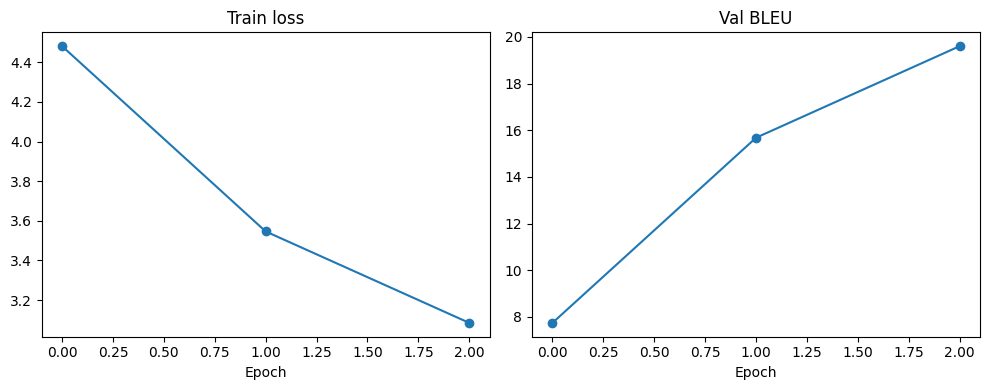

In [13]:
# Cell 13: plot training loss and val BLEU
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Train loss")
plt.xlabel("Epoch")
plt.subplot(1,2,2)
plt.plot(val_bleus, marker='o')
plt.title("Val BLEU")
plt.xlabel("Epoch")
plt.tight_layout()
plt.savefig("../results/loss_curve.png")
plt.show()

### 14. Inference

In [14]:
# Cell 14: helper to translate single sentence (uses model loaded already)
def translate_sentence(sentence, model, src_vocab, tgt_vocab, max_len=50):
    model.eval()
    tokens = tokenize_en(sentence)
    ids = src_vocab.numericalize(tokens)
    src_tensor = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
    src_len = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    with torch.no_grad():
        preds = model.greedy_decode(src_tensor, src_len, max_len=max_len,
                                    sos_idx=tgt_vocab.stoi[SOS_TOKEN],
                                    eos_idx=tgt_vocab.stoi[EOS_TOKEN])[0]
    words = []
    for idx in preds:
        if idx == tgt_vocab.stoi[EOS_TOKEN]:
            break
        words.append(tgt_vocab.itos[idx] if idx < len(tgt_vocab.itos) else UNK_TOKEN)
    return " ".join(words)

# demo
sent = "A man in a red shirt is playing a guitar."
print("SRC:", sent)
print("HYP:", translate_sentence(sent, model, src_vocab, tgt_vocab))

SRC: A man in a red shirt is playing a guitar.
HYP: un homme en t - shirt rouge joue sur un guitare .


### 15. Save environment

In [15]:
# Cell 15: create requirements.txt snapshot (runs in notebook; ensure pip is available)
#!pip freeze > ../requirements.txt
#print("Saved requirements.txt to project folder.")